# Imports

In [2]:
from __future__ import print_function, division

import sys  
import time
import os
import copy
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import ceil
from PIL import Image

import visdom
from IPython.display import clear_output
from PIL import Image
import nltk
from nltk.cluster.kmeans import KMeansClusterer

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity, pairwise_distances

sys.path.insert(0, '../Resnet/')
%load_ext autoreload
%autoreload 2
from model import *
from my_ImageFolder import *
from fairness_metrics import *

plt.ion()   # interactive mode

In /home/ghayat/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ghayat/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ghayat/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/ghayat/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ghayat/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

# Importing the dataset

In [3]:
path_bask_r_f = '../Datasets/basket_volley/basket/basket_f_r/'
path_bask_y_f = '../Datasets/basket_volley/basket/basket_f_y/'
path_bask_r_m = '../Datasets/basket_volley/basket/basket_m_r/'
path_bask_y_m = '../Datasets/basket_volley/basket/basket_m_y/'

bask_r_f = os.listdir(path_bask_r_f)
bask_y_f = os.listdir(path_bask_y_f)
bask_r_m = os.listdir(path_bask_r_m)
bask_y_m = os.listdir(path_bask_y_m)

path_voll_r_f = '../Datasets/basket_volley/volley/volley_f_r/'
path_voll_y_f = '../Datasets/basket_volley/volley/volley_f_y/'
path_voll_r_m = '../Datasets/basket_volley/volley/volley_m_r/'
path_voll_y_m = '../Datasets/basket_volley/volley/volley_m_y/'

voll_r_f = os.listdir(path_voll_r_f)
voll_y_f = os.listdir(path_voll_y_f)
voll_r_m = os.listdir(path_voll_r_m)
voll_y_m = os.listdir(path_voll_y_m)

class0_min, class1_min = bask_y_m + bask_y_f,voll_r_m + voll_r_f
protected_groups = set(class0_min + class1_min)

# Defining the inputs

In [5]:
W_PROTECTED, BIAS, VAL_MODE, START_EPOCH, NUM_EPOCH, SHOW_PROGRESS, ID, DATASET, NUM_TRIALS, BIAS = 1, 0.8, False, 0, 3, False, 0, "basket_volley", 1, 0.7

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../Datasets/basket_volley/train_test_split'
image_datasets = {
    x: my_ImageFolder(os.path.join(data_dir, f"train_{BIAS}" if x == "train" else x), data_transforms[x],
                      protected_groups, W_PROTECTED)
    for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Training Conv net

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 1, 4)
        self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 12, 5)
        # self.fc1 = nn.Linear(33708, 2048)
        self.fc2 = nn.Linear(12100, 512)
        self.fc3 = nn.Linear(512, len(class_names))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [9]:
net = Net()
net.fc2.register_forward_hook(get_activation('fc2'))

criterion = weighted_cross_entropy_loss # nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [11]:
net = train_model(net, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device,
                             start_epoch=START_EPOCH,
                             num_epochs=NUM_EPOCH,
                             val_mode=VAL_MODE, show_progress=SHOW_PROGRESS)

Epoch 0/2
----------
train Loss: 0.6831 Acc: 0.5303
Epoch 1/2
----------
train Loss: 0.6402 Acc: 0.6719
Epoch 2/2
----------
train Loss: 0.5717 Acc: 0.7382
Training complete in 0m 36s
Best val Acc: 0.000000


In [10]:
repr(net)

'Net(\n  (conv1): Conv2d(3, 1, kernel_size=(4, 4), stride=(1, 1))\n  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (fc2): Linear(in_features=12100, out_features=512, bias=True)\n  (fc3): Linear(in_features=512, out_features=2, bias=True)\n)'

In [12]:
print(f"Acc. on Training set: {float(accuracy(net, device, dataloaders['train']))}")
print(f"Acc. on Test set: {float(accuracy(net, device, dataloaders['test']))}")
print(f"Fairness measures")
print(demographic_parity(net, device, image_datasets["test"], [class0_min, class1_min]).to_numpy())

Acc. on Training set: 0.8842696629213483
Acc. on Test set: 0.5745721271393643
Fairness measures
[[0.95535714 0.52525253]
 [0.15533981 0.63157895]]


In [342]:
list_diff = []
for i, (w1, w2) in enumerate(zip(net.fc3.weight[0], net.fc3.weight[1])):
    list_diff.append((float(abs(w1-w2)), i))
list_diff.sort(reverse=True)
diffs = [i for _, i in list_diff[:100]]

#### Training Complete Resnet

In [19]:
layers_to_train = 2
model_conv = torchvision.models.resnet18(pretrained=True)
for i, param in enumerate(model_conv.parameters()):
    if i < len(list(model_conv.parameters())) -layers_to_train:
        param.requires_grad = False

In [20]:
model_conv = torchvision.models.resnet18(pretrained=True)

In [21]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = weighted_cross_entropy_loss  # nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [24]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, dataloaders, dataset_sizes, device,
                             start_epoch=START_EPOCH,
                             num_epochs=NUM_EPOCH,
                             val_mode=VAL_MODE, show_progress=SHOW_PROGRESS)

Epoch 0/2
----------
train Loss: 0.5059 Acc: 0.7908
Epoch 1/2
----------
train Loss: 0.5442 Acc: 0.7920
Epoch 2/2
----------
train Loss: 0.5581 Acc: 0.7638
Training complete in 6m 11s
Best val Acc: 0.000000


In [70]:
print(f"Acc. on Training set: {float(accuracy(model_conv, device, dataloaders['train']))}")
print(f"Acc. on Test set: {float(accuracy(model_conv, device, dataloaders['test']))}")
print(f"Fairness measures")
print(demographic_parity(model_conv, device, image_datasets["test"], [class0_min, class1_min]).to_numpy())

Acc. on Training set: 0.9396662387676509
Acc. on Test set: 0.8092909535452323
Fairness measures
[[0.94642857 0.70707071]
 [0.60194175 0.97894737]]


In [22]:
lists = []
for weights in model_conv.fc.weight:
    l = []
    for i, weight in enumerate(weights):
        l.append((abs(weight), i))   
    l.sort(reverse=True)
    lists.append(l)

In [33]:
list_diff = []
for i, (w1, w2) in enumerate(zip(model_conv.fc.weight[0], model_conv.fc.weight[1])):
    list_diff.append((abs(w1-w2), i))
list_diff.sort(reverse=True)

In [86]:
bask_dims = [i for _, i in lists[0][:200]]
voll_dims = [i for _, i in lists[1][:200]]
diffs = [i for _, i in list_diff[:1]]

In [72]:
model_repr = nn.Sequential(*list(model_conv.children())[:-1])

In [73]:
X_transform_0, X_transform_1 = np.array([[]]).reshape(0, model_conv.fc.in_features),np.array([[]]).reshape(0, model_conv.fc.in_features)
indexes_0, indexes_1 = np.array([]).astype(int), np.array([]).astype(int)
for inputs, label, _, index in dataloaders["train"]:
    output = model_repr(inputs).detach().numpy().reshape((inputs.shape[0], -1))
    for i, l in enumerate(label):
        if not l:
            X_transform_0 = np.concatenate([X_transform_0, output[i].reshape((1, -1))])
            indexes_0 = np.concatenate([indexes_0, index[i].numpy().reshape(-1)])
        else:
            X_transform_1 = np.concatenate([X_transform_1, output[i].reshape((1, -1))])
            indexes_1 = np.concatenate([indexes_1, index[i].numpy().reshape(-1)])

In [60]:
X_transform, indexes = np.array([[]]).reshape(0, model_conv.fc.in_features), np.array([]).astype(int)
for inputs, label, _, index in dataloaders["test"]:
    output = model_repr(inputs).detach().numpy().reshape((inputs.shape[0], -1))
    X_transform = np.concatenate([X_transform, output])
    indexes = np.concatenate([indexes, index.numpy().reshape(-1)])

#### Taking pretrained representation Resnet

In [55]:
X_transform = np.array([[]]).reshape(0,model_conv.fc.out_features)
for (inputs, label), weights in dataloaders["train"]:
    output = model_conv(inputs)
    X_transform = np.concatenate([X_transform, output])
indexes = list(range(len(image_datasets["train"])))

#### Extracting represenation

In [13]:
X_transform_0, X_transform_1 = np.array([[]]).reshape(0, net.fc2.out_features),np.array([[]]).reshape(0, net.fc2.out_features)
indexes_0, indexes_1 = np.array([]).astype(int), np.array([]).astype(int)

for i, (inputs, labels, clusters, index) in enumerate(dataloaders["train"]):
    output = net(inputs)
    output = activation['fc2']
    for j, l in enumerate(labels):
        if not l:
            X_transform_0 = np.concatenate([X_transform_0, output[j].numpy().reshape((1, -1))])
            indexes_0 = np.concatenate([indexes_0, index[j].numpy().reshape(-1)])
        else:
            X_transform_1 = np.concatenate([X_transform_1, output[j].numpy().reshape((1, -1))])
            indexes_1 = np.concatenate([indexes_1, index[j].numpy().reshape(-1)])

#### PCA reduction with pretrained repr

In [93]:
X_transform = np.concatenate([X_transform_0, X_transform_1], axis=0)
indexes = np.concatenate([indexes_0, indexes_1], axis=0)

In [14]:
pca = PCA(n_components=10)

X_reducted = pca.fit_transform(X_transform)

km = KMeans(n_clusters=2, random_state=0)
kmeans = km.fit_predict(X_reducted)
path = os.path.join(data_dir, "train_0.8")

NameError: name 'X_transform' is not defined

In [15]:
pca_0 = PCA(n_components=10)
pca_1 = PCA(n_components=10)

X_reducted_0 = pca_0.fit_transform(X_transform_0)
X_reducted_1 = pca_1.fit_transform(X_transform_1)

In [16]:
eigenvalues_0 = pca_0.explained_variance_
eigenvalues_1 = pca_1.explained_variance_
eigenvalues_0, eigenvalues_1

(array([9.8595278 , 5.22934493, 2.93352112, 1.23811199, 0.81359392,
        0.5705303 , 0.48944479, 0.39986028, 0.3620637 , 0.30889011]),
 array([6.15284965, 1.55439645, 1.06857269, 0.74953374, 0.65017528,
        0.48856856, 0.35443331, 0.32214659, 0.3110144 , 0.29093354]))

In [27]:
km_0 = KMeans(n_clusters=2, random_state=0)
km_1 = KMeans(n_clusters=2, random_state=0)

kmeans_0 = km_0.fit_predict(X_reducted_0)
kmeans_1 = km_1.fit_predict(X_reducted_1)

# path = os.path.join(data_dir, "train_0.8")

In [20]:
def my_distance_0(v1, v2):
    dist = 0
    for i, (c1, c2) in enumerate(zip(v1, v2)):
        dist += eigenvalues_0[i] * float(abs(c1 - c2))
    return dist

def my_distance_1(v1, v2):
    dist = 0
    for i, (c1, c2) in enumerate(zip(v1, v2)):
        dist += eigenvalues_1[i] * float(abs(c1 - c2))
    return dist

In [21]:
km_0 = KMeansClusterer(2, distance=my_distance_0, repeats=25) # nltk.cluster.util.cosine_distance
km_1 = KMeansClusterer(2, distance=my_distance_1, repeats=25) # nltk.cluster.util.cosine_distance

kmeans_0 = km_0.cluster(X_reducted_0, assign_clusters=True)
kmeans_1 = km_1.cluster(X_reducted_1, assign_clusters=True)

In [65]:
X_reducted = pca.transform(X_transform)
kmeans = km.predict(X_reducted)
path = os.path.join(data_dir, "test")

In [24]:
cluster_paths = view_clusters(".", kmeans_1, indexes_1)

In [75]:
max_diff, max_i = 0, -1
for i in range(X_reducted_0.shape[1]):
    km_0 = KMeans(n_clusters=2, random_state=0)
    km_1 = KMeans(n_clusters=2, random_state=0)

    kmeans_0 = km_0.fit_predict(X_reducted_0[:, i].reshape((-1, 1)))
    kmeans_1 = km_1.fit_predict(X_reducted_1[:, i].reshape((-1, 1)))
        
    bask = statistics_colors(list_clusters(path, kmeans_0, indexes_0))
    volley = statistics_colors(list_clusters(path, kmeans_1, indexes_1))
    
    if (abs(bask[0] - bask[1]) + abs(volley[0] - volley[1]))/2 > max_diff:
        max_diff = (abs(bask[0] - bask[1]) + abs(volley[0] - volley[1]))/2
        max_i = i

In [67]:
statistics_colors(list_clusters(path, kmeans, indexes))

[0.24850299401197604, 0.7325842696629213]

In [14]:
data_dir = r"clustering_2/conv"
path = os.path.join(data_dir, "dimensions/")

In [18]:
for i in range(X_reducted_0.shape[1]):
    
    km_0 = KMeans(n_clusters=2, random_state=0)
    km_1 = KMeans(n_clusters=2, random_state=0)

    kmeans_0 = km_0.fit_predict(X_reducted_0[:, i].reshape((-1, 1)))
    kmeans_1 = km_1.fit_predict(X_reducted_1[:, i].reshape((-1, 1)))

    dim_path = os.path.join(path, f"dim_{i}")
    os.makedirs(dim_path, exist_ok=True)
            
    print("-"*15, f"dim_{i}", "-"*15)
    cluster_paths = view_clusters(os.path.join(dim_path, "basket"), kmeans_0, indexes_0)
    print("Basket")
    statistics(os.path.join(dim_path, "basket"), cluster_paths)
                            
    cluster_paths = view_clusters(os.path.join(dim_path, "volley"), kmeans_1, indexes_1)
    print("Voll")
    statistics(os.path.join(dim_path, "volley"), cluster_paths)

--------------- dim_0 ---------------
Basket
--------------Cluster 0--------- 
 n. samples: 181
 n. of bask: 181 (100.0%)
 n. of volley: 0 (0.0%)
 n. of red: 97 (53.6%)
 n. of yellow: 84 (46.4%)
 n. of males: 82 (45.3%)
 n. of females: 99 (54.7%)
--------------Cluster 1--------- 
 n. samples: 241
 n. of bask: 241 (100.0%)
 n. of volley: 0 (0.0%)
 n. of red: 241 (100.0%)
 n. of yellow: 0 (0.0%)
 n. of males: 114 (47.3%)
 n. of females: 127 (52.7%)
Voll
--------------Cluster 0--------- 
 n. samples: 295
 n. of bask: 0 (0.0%)
 n. of volley: 295 (100.0%)
 n. of red: 11 (3.7%)
 n. of yellow: 284 (96.3%)
 n. of males: 139 (47.1%)
 n. of females: 156 (52.9%)
--------------Cluster 1--------- 
 n. samples: 62
 n. of bask: 0 (0.0%)
 n. of volley: 62 (100.0%)
 n. of red: 60 (96.8%)
 n. of yellow: 2 (3.2%)
 n. of males: 32 (51.6%)
 n. of females: 30 (48.4%)
--------------- dim_1 ---------------
Basket
--------------Cluster 0--------- 
 n. samples: 270
 n. of bask: 270 (100.0%)
 n. of volley: 0 (0.

Voll
--------------Cluster 0--------- 
 n. samples: 204
 n. of bask: 0 (0.0%)
 n. of volley: 204 (100.0%)
 n. of red: 33 (16.2%)
 n. of yellow: 171 (83.8%)
 n. of males: 99 (48.5%)
 n. of females: 105 (51.5%)
--------------Cluster 1--------- 
 n. samples: 153
 n. of bask: 0 (0.0%)
 n. of volley: 153 (100.0%)
 n. of red: 38 (24.8%)
 n. of yellow: 115 (75.2%)
 n. of males: 72 (47.1%)
 n. of females: 81 (52.9%)


In [79]:
for i in range(X_reducted_0.shape[1]):
    
    km_0 = KMeans(n_clusters=2, random_state=0)
    km_1 = KMeans(n_clusters=2, random_state=0)

    kmeans_0 = km_0.fit_predict(X_reducted_0[:, i].reshape((-1, 1)))
    kmeans_1 = km_1.fit_predict(X_reducted_1[:, i].reshape((-1, 1)))

    dim_path = os.path.join(path, f"dim_{i}")
    os.makedirs(dim_path, exist_ok=True)
            
    print("-"*15, f"dim_{i}", "-"*15)
    cluster_paths = view_clusters(os.path.join(dim_path, "basket"), kmeans_0, indexes_0)
    print("Basket")
    statistics(os.path.join(dim_path, "basket"), cluster_paths)
                            
    cluster_paths = view_clusters(os.path.join(dim_path, "volley"), kmeans_1, indexes_1)
    print("Voll")
    statistics(os.path.join(dim_path, "volley"), cluster_paths)

--------------- dim_0 ---------------
Basket
--------------Cluster 0--------- 
 n. samples: 204
 n. of bask: 204 (100.0%)
 n. of volley: 0 (0.0%)
 n. of red: 151 (74.0%)
 n. of yellow: 53 (26.0%)
 n. of males: 125 (61.3%)
 n. of females: 79 (38.7%)
--------------Cluster 1--------- 
 n. samples: 218
 n. of bask: 218 (100.0%)
 n. of volley: 0 (0.0%)
 n. of red: 187 (85.8%)
 n. of yellow: 31 (14.2%)
 n. of males: 71 (32.6%)
 n. of females: 147 (67.4%)
Voll
--------------Cluster 0--------- 
 n. samples: 194
 n. of bask: 0 (0.0%)
 n. of volley: 194 (100.0%)
 n. of red: 30 (15.5%)
 n. of yellow: 164 (84.5%)
 n. of males: 114 (58.8%)
 n. of females: 80 (41.2%)
--------------Cluster 1--------- 
 n. samples: 163
 n. of bask: 0 (0.0%)
 n. of volley: 163 (100.0%)
 n. of red: 41 (25.2%)
 n. of yellow: 122 (74.8%)
 n. of males: 57 (35.0%)
 n. of females: 106 (65.0%)
--------------- dim_1 ---------------
Basket
--------------Cluster 0--------- 
 n. samples: 202
 n. of bask: 202 (100.0%)
 n. of volle

Voll
--------------Cluster 0--------- 
 n. samples: 186
 n. of bask: 0 (0.0%)
 n. of volley: 186 (100.0%)
 n. of red: 16 (8.6%)
 n. of yellow: 170 (91.4%)
 n. of males: 63 (33.9%)
 n. of females: 123 (66.1%)
--------------Cluster 1--------- 
 n. samples: 171
 n. of bask: 0 (0.0%)
 n. of volley: 171 (100.0%)
 n. of red: 55 (32.2%)
 n. of yellow: 116 (67.8%)
 n. of males: 108 (63.2%)
 n. of females: 63 (36.8%)


### Basket

In [23]:
### Kmeans with custom distance metric - this make the color attribute even more important
statistics(".", cluster_paths)

--------------Cluster 0--------- 
 n. samples: 290
 n. of bask: 290 (100.0%)
 n. of volley: 0 (0.0%)
 n. of red: 150 (51.7%)
 n. of yellow: 140 (48.3%)
 n. of males: 146 (50.3%)
 n. of females: 144 (49.7%)
--------------Cluster 1--------- 
 n. samples: 192
 n. of bask: 192 (100.0%)
 n. of volley: 0 (0.0%)
 n. of red: 188 (97.9%)
 n. of yellow: 4 (2.1%)
 n. of males: 89 (46.4%)
 n. of females: 103 (53.6%)


### Volley

In [25]:
### Kmeans with cosine_distance
statistics(".", cluster_paths)

--------------Cluster 0--------- 
 n. samples: 302
 n. of bask: 0 (0.0%)
 n. of volley: 302 (100.0%)
 n. of red: 29 (9.6%)
 n. of yellow: 273 (90.4%)
 n. of males: 146 (48.3%)
 n. of females: 156 (51.7%)
--------------Cluster 1--------- 
 n. samples: 106
 n. of bask: 0 (0.0%)
 n. of volley: 106 (100.0%)
 n. of red: 93 (87.7%)
 n. of yellow: 13 (12.3%)
 n. of males: 53 (50.0%)
 n. of females: 53 (50.0%)


### Finding representative images of the clusters

In [741]:
l0c0, l0c1 = proximity(pca_0, km_0, X_reducted_0, indexes_0, kmeans_0)
l1c0, l1c1 = proximity(pca_1, km_1, X_reducted_1, indexes_1, kmeans_1)

In [54]:
im0c0, im0c1 = bask[l0c0[0][1]], bask[l0c1[0][1]]
im1c0, im1c1 = voll[l1c0[1][1]], voll[l1c1[1][1]]
im0c0, im0c1, im1c0, im1c1

('images63_218.jpg',
 'images81_233.jpg',
 'image17_1080.jpeg',
 'images499_1616.jpg')

##### Showing closest 10 images of each cluster

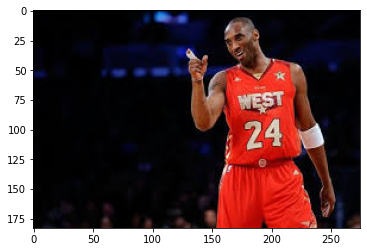

1.0528430539006552


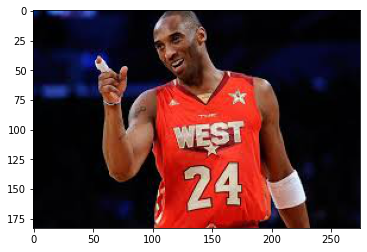

1.5849254849779317


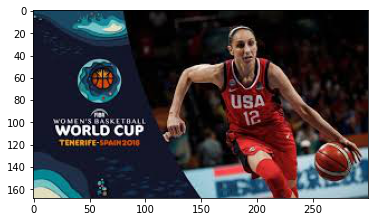

1.7546869709849755


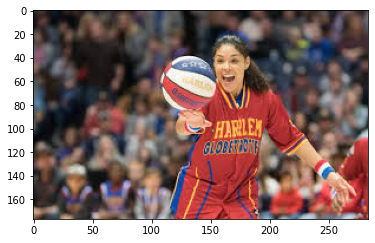

1.8139485826579236


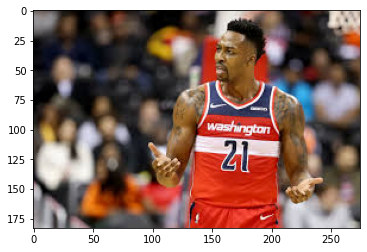

1.9980760761149257


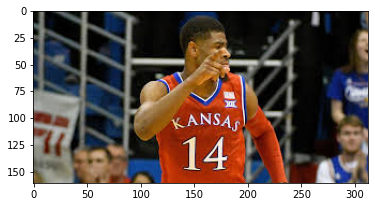

2.0410929911503146


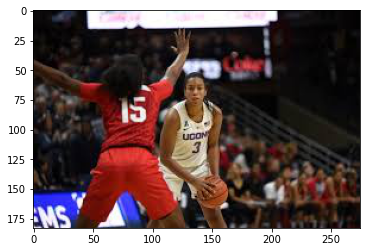

2.0825819652950384


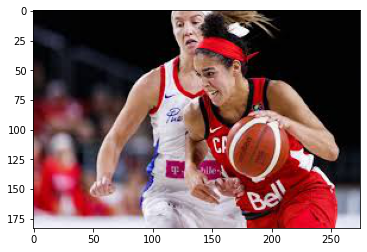

2.103247756687742


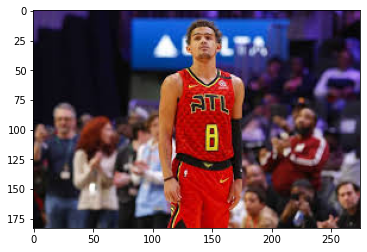

2.3432890279442993


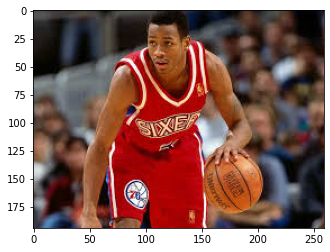

2.4541387871009652


In [743]:
show_closest(l0c0, top_k=10)

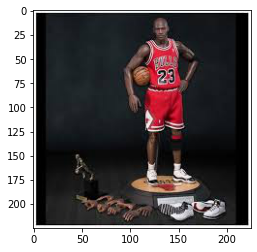

1.623492816526375


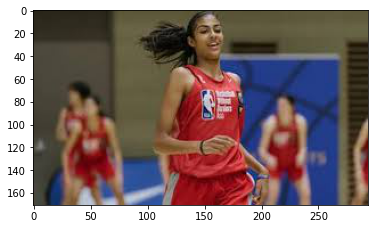

1.7720648105585224


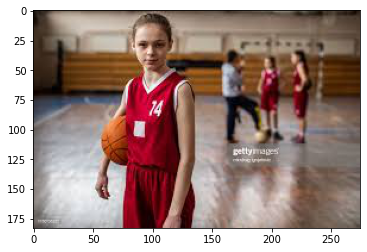

1.871689949024597


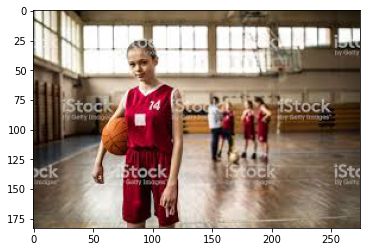

1.9302118900952614


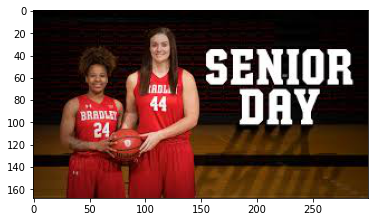

2.188506764785708


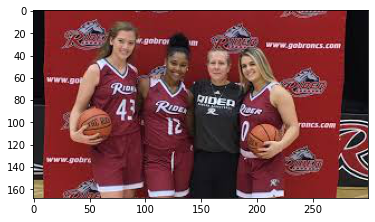

2.4484484923631795


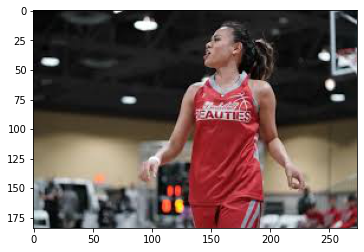

2.487820035677472


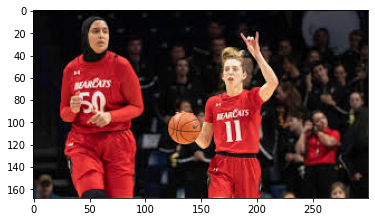

2.509772039024844


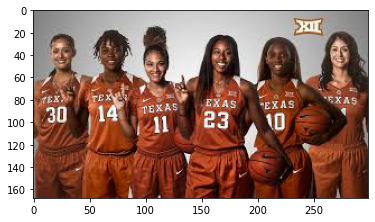

2.618804457890035


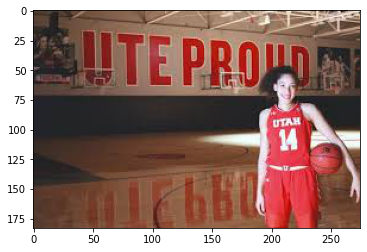

2.636485515767897


In [742]:
show_closest(l0c1, top_k=10)

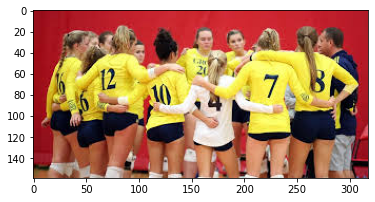

2.529640983013366


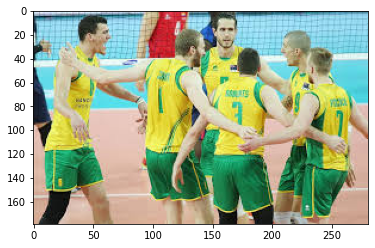

2.5386945903521485


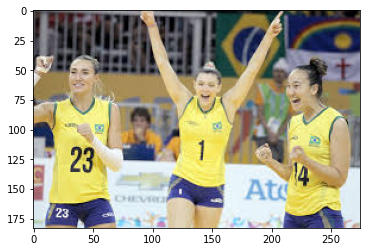

2.691970482682932


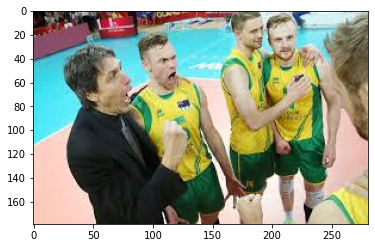

2.811815759331142


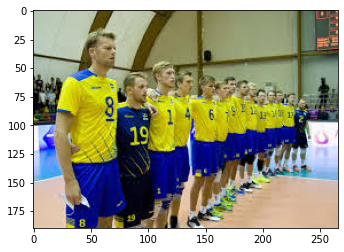

2.9341588674497627


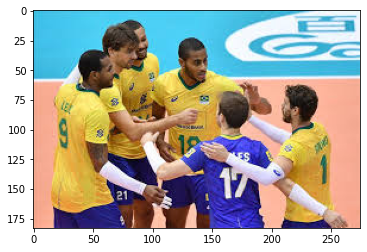

2.9726067380228316


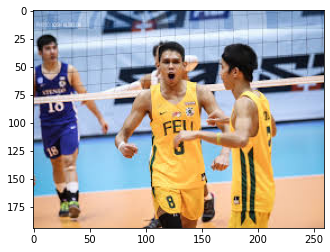

3.0208589456256476


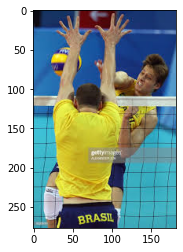

3.058167542091141


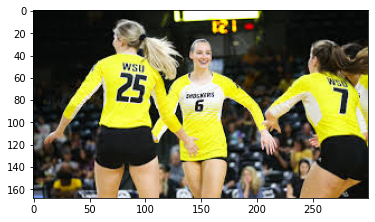

3.1614531822795207


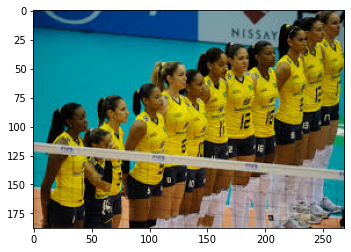

3.1768186351347163


In [698]:
show_closest(l1c0, top_k=10)

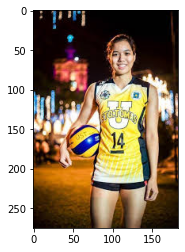

0.4153222507208458


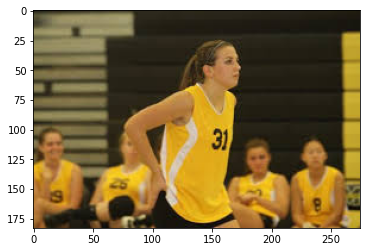

0.6469049286262686


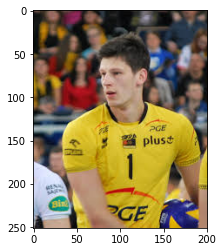

1.0545331668513687


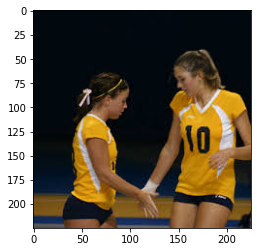

1.2794636765090688


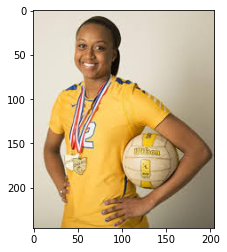

1.3031277927766705


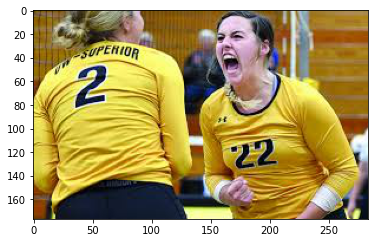

1.3695467448893495


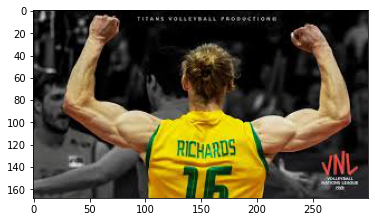

1.3750055978101572


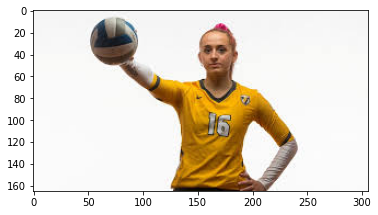

1.4100052120780433


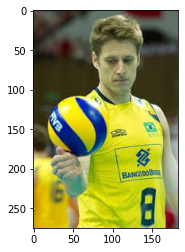

1.5191317276069254


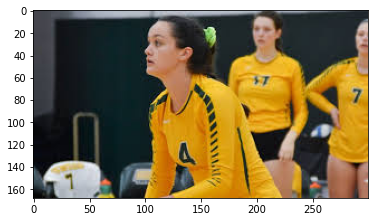

1.5366146042490993


In [699]:
show_closest(l1c1, top_k=10)

### Computing proximity images

In [750]:
i = 180
img_name = image_datasets["train"].samples[indexes_0[i]][0]
img_emb = X_transform_0[i]

In [745]:
indexes_0[i]

18

In [746]:
img_name

'../Datasets/basket_volley/train_test_split/train_0.8/basket/Gabby_Williams_28cropped29_254.jpg'

In [747]:
for inputs, _, _, indexes in dataloaders["train"]:
    output = model_repr(inputs).detach().numpy().reshape((inputs.shape[0], -1))
    for idx, o in zip(indexes, output):
        if np.array_equal(o, img_emb):
            print(idx)

tensor(18)


In [583]:
bask_i, voll_i = 0, 1
def my_distance(emb1, emb2):
    emb1, emb2 = emb1.reshape((-1)), emb2.reshape((-1))
    dist = 0
    for i, w in enumerate(net.fc3.weight[bask_i]):
        dist += abs(w) * float(abs(emb1[i] - emb2[i]))
    return dist

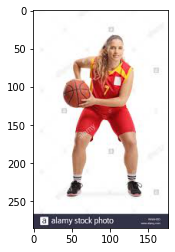

[[1.]]


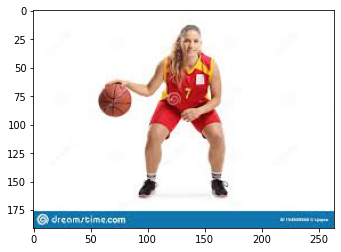

[[0.78711482]]


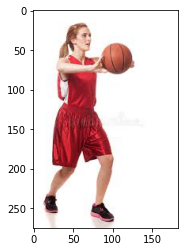

[[0.77783713]]


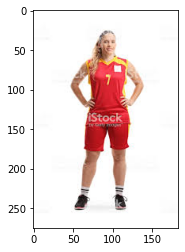

[[0.75714604]]


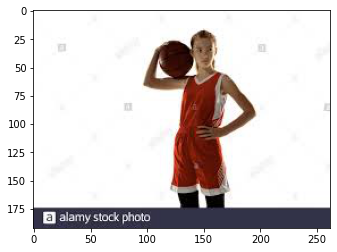

[[0.7480447]]


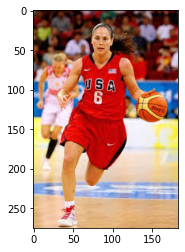

[[0.72223149]]


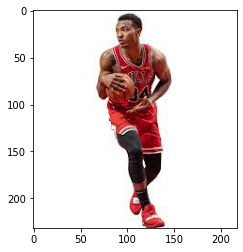

[[0.71629382]]


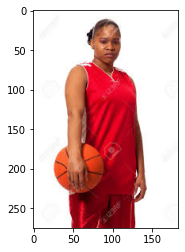

[[0.7132587]]


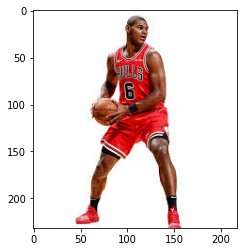

[[0.70941256]]


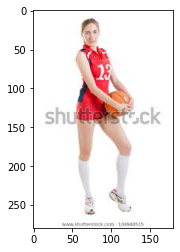

[[0.70904381]]


In [697]:
show_closest(closest_to(img_emb, X_transform_0, indexes_0, descending=True), top_k=10)

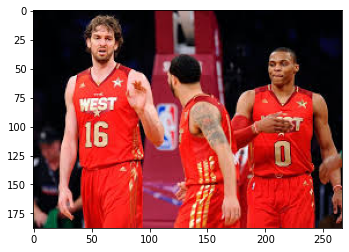

[[1.]]


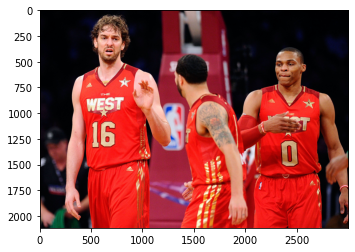

[[0.91524719]]


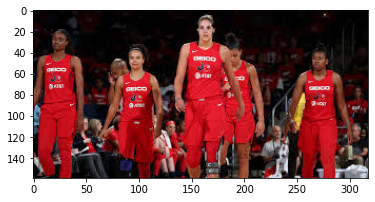

[[0.79734507]]


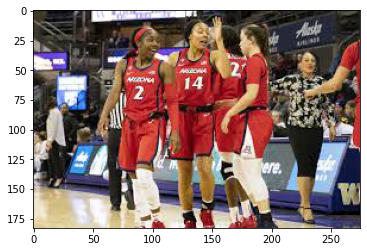

[[0.77239943]]


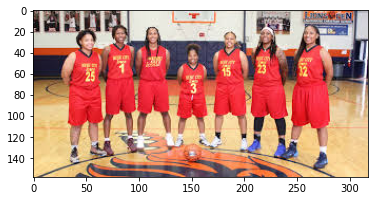

[[0.76968352]]


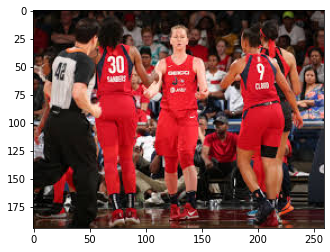

[[0.76409513]]


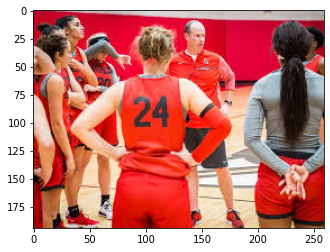

[[0.7583634]]


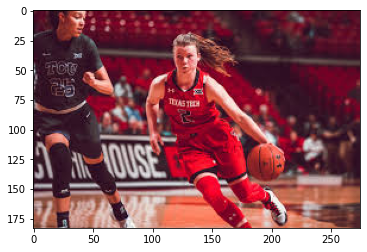

[[0.75771593]]


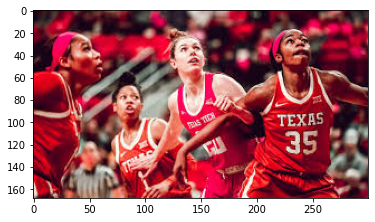

[[0.75697116]]


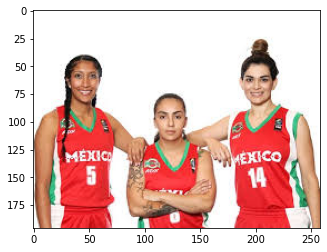

[[0.75695429]]


In [751]:
show_closest(closest_to(img_emb, X_transform_0, indexes_0, descending=True), top_k=10)

#### Helper functions

In [632]:
image_datasets["train"].samples[0][0].split("/")[-1]

'021315-Sports-Best-NBA-All-Star-Jerseys-2011-Chris-Paul-Carmelo-Anthony-Kobe-Bryant_432.jpg'

In [21]:
dict = make_save_dict(image_datasets["train"].samples, [kmeans_0, kmeans_1], [indexes_0, indexes_1], save=True, name="conv_0.5.txt")

In [792]:
len(dict), len(image_datasets["train"].samples)

(779, 779)

In [19]:
def show_closest(list, top_k=5):
    for i in range(top_k):
        img_show(list[i][1])
        print(list[i][0])
        
def img_show(i):
    # clear_output(wait=True)
    image = Image.open(image_datasets["train"].samples[i][0], "r")
    plt.imshow(np.asarray(image))
    plt.show()

def view_clusters(path, kmeans, indexes):
    K = len(set(kmeans))
    
    paths = []
    for k in range(K):
        paths.append(os.path.join(path, f"clustering_{K}/cluster_{k}"))
        os.makedirs(paths[-1], exist_ok=True)
        
    for i in range(len(kmeans)):
        src = image_datasets["train"].samples[indexes[i]][0]
        dst = os.path.join(path, f"clustering_{K}/cluster_{kmeans[i]}/") + src.split("/")[-1]
        shutil.copy(src, dst)
    
    return paths

def list_clusters(path, kmeans, indexes):
    K = len(set(kmeans))
    bask, voll = os.listdir(os.path.join(path, "basket")), os.listdir(os.path.join(path, "volley"))
    
    lists = [[] for _ in range(K)]
    for i in range(len(kmeans)):
        src = bask[indexes[i]] if indexes[i] < len(bask) else voll[indexes[i] - len(bask)]
        lists[kmeans[i]].append(src)
        
    return lists

def proximity(pca, km, X_reducted, indexes, kmeans):
    proj = pca.inverse_transform(km.cluster_centers_)
    list_0, list_1 = [], []
    for rep, id, c in zip(X_reducted, indexes, kmeans):
        dist = mse(rep, km.cluster_centers_[0]) if not c else mse(rep, km.cluster_centers_[1])
        list_1.append((dist, id)) if c else list_0.append((dist, id))      
    list_0.sort(), list_1.sort()
    return list_0, list_1

def closest_to(emb, X_transform, indexes, metric=cosine_similarity, descending=False):
    l = []
    for i, (emb2, idx) in enumerate(zip(X_transform, indexes)):
        dist = metric(emb.reshape((1, -1)), emb2.reshape((1, -1)))
        l.append((dist, idx))
    l.sort(reverse=descending)
    return l

def statistics(path, clusters):
    K = len(set(clusters))
    
    for k in range(K):
        n_bask, n_voll, n_r, n_y, n_m, n_f = 0, 0, 0, 0, 0, 0
        cluster = os.listdir(clusters[k])
        for img in cluster:
            if img in bask_r_f:
                n_bask += 1
                n_f += 1
                n_r += 1
                
            if img in bask_r_m:
                n_bask += 1
                n_m += 1
                n_r += 1
                
            if img in bask_y_f:
                n_bask += 1
                n_f += 1
                n_y += 1
            
            if img in bask_y_m:
                n_bask += 1
                n_m += 1
                n_y += 1
            
            if img in voll_r_f:
                n_voll += 1
                n_f += 1
                n_r += 1
            
            if img in voll_r_m:
                n_voll += 1
                n_m += 1
                n_r += 1
                
            if img in voll_y_f:
                n_voll += 1
                n_f += 1
                n_y += 1
            
            if img in voll_y_m:
                n_voll += 1
                n_m += 1
                n_y += 1
                
        
        print(f"--------------Cluster {k}--------- \n n. samples: {len(cluster)}\n n. of bask: {n_bask} ({n_bask/len(cluster)*100:.1f}%)\n n. of volley: {n_voll} ({n_voll/len(cluster)*100:.1f}%)\n n. of red: {n_r} ({n_r/len(cluster)*100:.1f}%)\n n. of yellow: {n_y} ({n_y/len(cluster)*100:.1f}%)\n n. of males: {n_m} ({n_m/len(cluster)*100:.1f}%)\n n. of females: {n_f} ({n_f/len(cluster)*100:.1f}%)")
        
def statistics_colors(clusters, K=2):
    stats = []
    for k in range(K):
        n_r, n_y = 0, 0
        cluster = clusters[k]
        for img in cluster:
            if img in bask_r_f or img in bask_r_m or img in voll_r_f or img in voll_r_m:
                n_r += 1
            else:
                n_y += 1
        stats.append(n_r/(n_r+n_y))
    return stats

def make_save_dict(samples, k_means_list, indexes_list, save=False, name="dict.txt"):
    dic = {}
    for k_means, indexes in zip(k_means_list, indexes_list):
        for cluster, idx in zip(k_means, indexes):
            img = samples[idx][0].split("/")[-1]
            dic[img] = cluster
       
    if save:
        f = open(name, "a")
        f.write(str(dic))
        f.close()
    
    return dic